In [41]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import xgboost
import shap
import os
import sys
import collections


import seaborn as sns

from sklearn import metrics
from scipy import stats
from scipy.stats import entropy

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn import metrics
from sklearn import preprocessing
from econml.dr import LinearDRLearner

module_path = os.path.abspath(os.path.join('CATENets/'))
if module_path not in sys.path:
    sys.path.append(module_path)

from catenets.models.jax import TNet, SNet,SNet1, SNet2, SNet3, DRNet, RANet, PWNet, RNet, XNet
from catenets.experiment_utils.simulation_utils import simulate_treatment_setup

In [2]:
fluid_cohort = pd.read_pickle("data/low_bp_2.pkl")

In [3]:
#### filtering out procedure


fluid_cohort = fluid_cohort[fluid_cohort.columns.drop(list(fluid_cohort.filter(regex='proc')))]
fluid_cohort

,registryid,age,scenegcs,scenegcseye,scenegcsmotor,scenegcsverbal,scenefirstbloodpressure,scenefirstpulse,scenefirstrespirationrate,edfirstbp,...,toxicologyresults_BARB,toxicologyresults_BEN,toxicologyresults_COC,toxicologyresults_MARI,toxicologyresults_MDN,toxicologyresults_METH,toxicologyresults_NEG,toxicologyresults_OPIA,toxicologyresults_PCP,toxicologyresults_TRI
0,2797*HMC,18.0,NaN,NaN,NaN,NaN,70.0,130.0,20.0,76.0,...,0,0,0,0,0,0,0,0,0,0
1,5270*HMC,20.0,15.0,4.0,6.0,5.0,70.0,110.0,28.0,120.0,...,0,0,0,0,0,0,0,0,0,0
2,5916*HMC,40.0,4.0,2.0,1.0,1.0,58.0,112.0,24.0,94.0,...,0,1,1,0,0,0,0,0,0,0
3,5975*HMC,58.0,NaN,1.0,1.0,1.0,80.0,73.0,NaN,138.0,...,0,0,0,0,0,0,0,0,0,0
4,6844*HMC,56.0,14.0,NaN,NaN,NaN,68.0,96.0,22.0,151.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
825,64095*HMC,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.0,...,0,0,0,0,0,0,1,0,0,0
826,64312*HMC,70.0,3.0,1.0,1.0,1.0,92.0,118.0,15.0,67.0,...,0,0,0,1,0,0,0,0,0,0
827,64567*HMC,59.0,15.0,4.0,6.0,5.0,86.0,93.0,22.0,97.0,...,0,0,0,0,0,0,0,0,0,0
828,64669*HMC,69.0,15.0,4.0,6.0,5.0,120.0,80.0,16.0,89.0,...,0,0,0,0,0,0,0,0,0,0


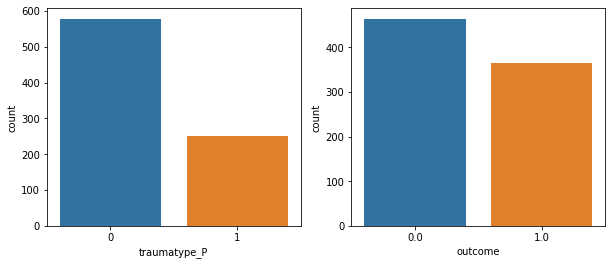

In [4]:
plt.figure(figsize=(10,4))
plt.subplot(1,2 ,1)
ax = sns.countplot(x="traumatype_P", data=fluid_cohort,\
                   order = fluid_cohort['traumatype_P'].value_counts().index)
plt.subplot(1,2 ,2)
ax = sns.countplot(x="outcome", data=fluid_cohort,\
                   order = fluid_cohort['outcome'].value_counts().index)

In [23]:

x_train = fluid_cohort.loc[:, ~fluid_cohort.columns.isin(["registryid","treated","outcome"])]
### normalize x_train 

#x = x_train.values 
min_max_scaler = preprocessing.MinMaxScaler()
x_train_scaled = min_max_scaler.fit_transform(x_train)

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(x_train_scaled)
x_train_scaled = imp.transform(x_train_scaled)

n = x_train.shape[0]

rng = np.random.default_rng(0)
inds = np.arange(n)
rng.shuffle(inds)

n_train = int(0.8 * n)

train_inds = inds[:n_train]
test_inds = inds[n_train:]

X_train, X_test = x_train_scaled[train_inds], x_train_scaled[test_inds]
w_train, w_test = fluid_cohort["treated"].values[train_inds], fluid_cohort["treated"].values[test_inds]
y_train, y_test = fluid_cohort["outcome"].values[train_inds], fluid_cohort["outcome"].values[test_inds]

print(X_train.shape, X_test.shape)

top_k_results = []

(664, 82) (166, 82)


In [42]:
models = [TNet(),  DRNet(), RANet(), PWNet(), XNet(),
         SNet() , SNet1(), SNet2(), SNet3()]

In [44]:
#### Getting top 10 features from multiple runs. 

top_k_results = []
names = x_train.columns
seeds = np.arange(0, 4, 0.5, dtype=int)


for i in seeds:
    np.random.seed(i)
    for model in models:

        model.fit(X_train, y_train, w_train)

        def model_predict(X):
            return model.predict(X)

        explainer = shap.Explainer(model_predict, X_train)

        #### showing explanation on cate
        shap_values = explainer(X_test)
        ind = np.argpartition(np.abs(shap_values.values).mean(0).round(2), -10)[-10:]
        top_k_results.append(names[ind].tolist())

results = collections.Counter(top_k_results)
summary = pd.DataFrame(results.items(), columns=['feature', 'count (%)']).sort_values(by="count (%)", ascending=False)
summary["count (%)"] = np.round(summary["count (%)"]/(len(models)*len(seeds)),2)*100

summary

Permutation explainer: 167it [00:25,  4.02it/s]                         
Permutation explainer: 167it [00:17,  4.11it/s]                         
Permutation explainer: 167it [00:17,  4.00it/s]                         
Permutation explainer: 167it [00:16,  3.96it/s]                         
Permutation explainer: 167it [00:36,  3.32it/s]                         
Permutation explainer: 167it [00:34,  3.47it/s]                         
Permutation explainer:  76%|███████▌  | 126/166 [00:29<00:13,  2.93it/s]


KeyboardInterrupt: 

Permutation explainer: 167it [00:18,  4.06it/s]                         


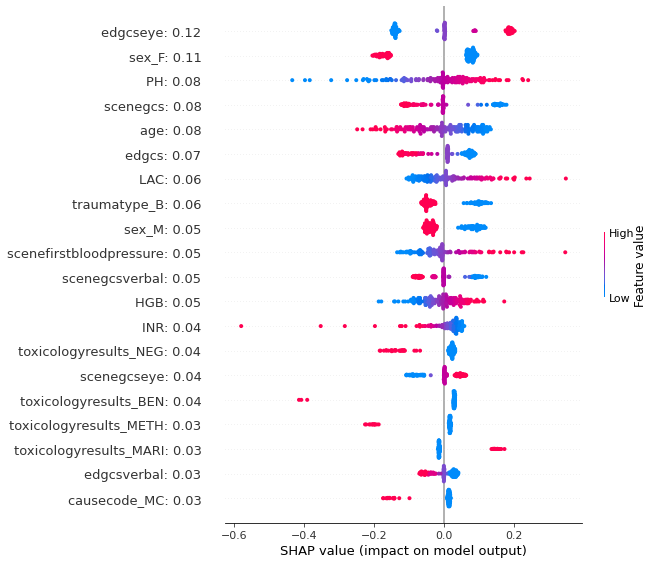

In [24]:
### single learner as oracle
dr = DRNet()
dr.fit(X_train, y_train, w_train)

def dr_predict(X):
    return dr.predict(X)

explainer = shap.Explainer(dr_predict, X_train)

#### showing explanation on cate
shap_values = explainer(X_test)

names = x_train.columns
feature_names = [ a + ": " + str(b) for a,b in zip(names, np.abs(shap_values.values).mean(0).round(2))]

ind = np.argpartition(np.abs(shap_values.values).mean(0).round(2), -10)[-10:]
top_k_results.append(names[ind].tolist())

shap.summary_plot(shap_values, feature_names=feature_names)

Permutation explainer: 167it [00:34,  3.34it/s]                         


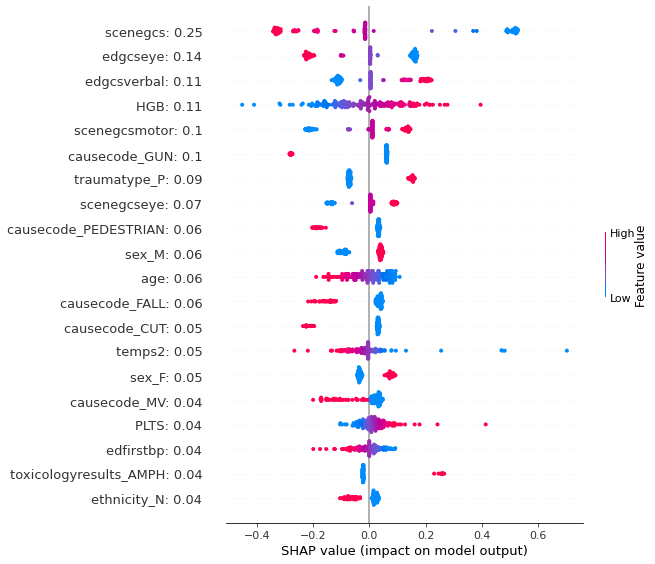

In [25]:
### single learner as oracle
s = SNet()
s.fit(X_train, y_train, w_train)

def s_predict(X):
    return s.predict(X)

explainer = shap.Explainer(s_predict, X_train)

#### showing explanation on cate
shap_values = explainer(X_test)

names = x_train.columns
feature_names = [ a + ": " + str(b) for a,b in zip(names, np.abs(shap_values.values).mean(0).round(2))]

ind = np.argpartition(np.abs(shap_values.values).mean(0).round(2), -10)[-10:]
top_k_results.append(names[ind].tolist())

shap.summary_plot(shap_values, feature_names=feature_names)

Permutation explainer: 167it [00:41,  3.15it/s]                         


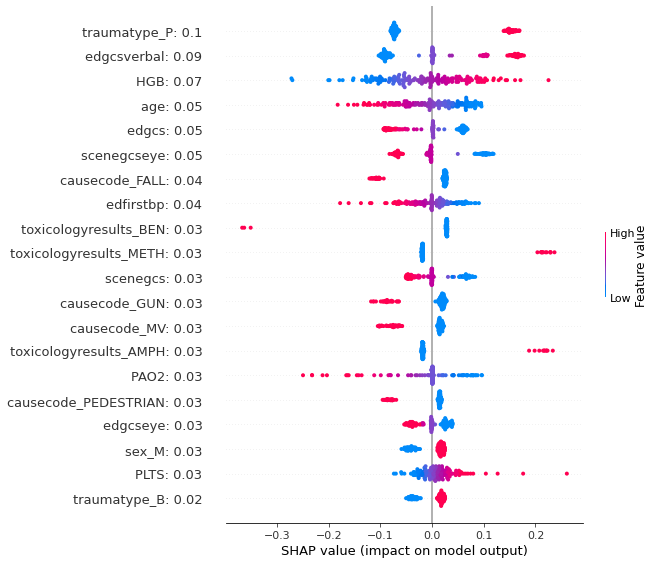

In [26]:
### single learner as oracle
s = SNet2()
s.fit(X_train, y_train, w_train)

def s_predict(X):
    return s.predict(X)

explainer = shap.Explainer(s_predict, X_train)

#### showing explanation on cate
shap_values = explainer(X_test)

names = x_train.columns
feature_names = [ a + ": " + str(b) for a,b in zip(names, np.abs(shap_values.values).mean(0).round(2))]

ind = np.argpartition(np.abs(shap_values.values).mean(0).round(2), -10)[-10:]
top_k_results.append(names[ind].tolist())

shap.summary_plot(shap_values, feature_names=feature_names)

Permutation explainer: 167it [00:29,  3.74it/s]                         


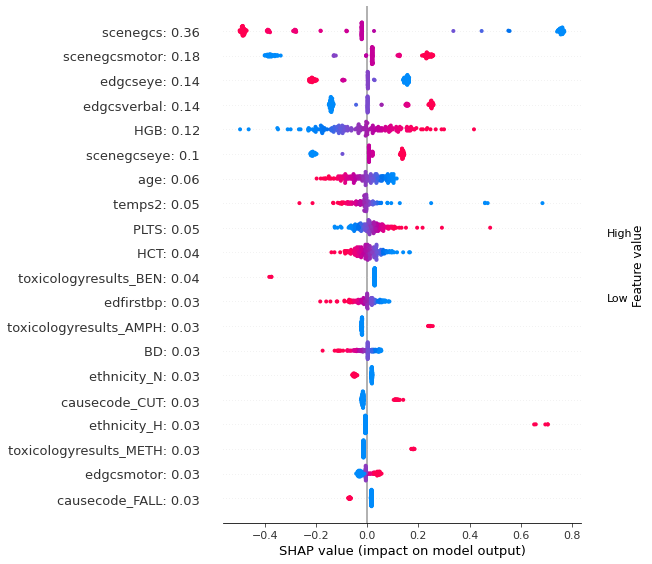

In [27]:
### single learner as oracle
s = SNet3()
s.fit(X_train, y_train, w_train)

def s_predict(X):
    return s.predict(X)

explainer = shap.Explainer(s_predict, X_train)

#### showing explanation on cate
shap_values = explainer(X_test)

names = x_train.columns
feature_names = [ a + ": " + str(b) for a,b in zip(names, np.abs(shap_values.values).mean(0).round(2))]

ind = np.argpartition(np.abs(shap_values.values).mean(0).round(2), -10)[-10:]
top_k_results.append(names[ind].tolist())

shap.summary_plot(shap_values, feature_names=feature_names)

Permutation explainer: 167it [00:27,  3.84it/s]                         


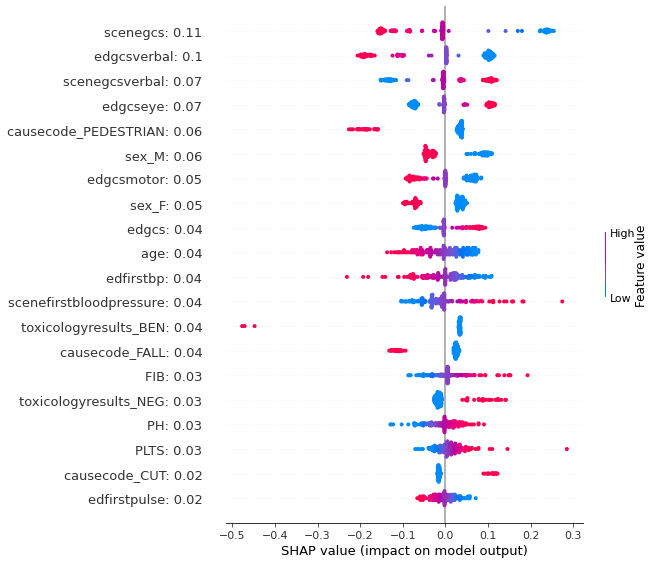

In [28]:
### single learner as oracle
s = TNet()
s.fit(X_train, y_train, w_train)

def s_predict(X):
    return s.predict(X)

explainer = shap.Explainer(s_predict, X_train)

#### showing explanation on cate
shap_values = explainer(X_test)

names = x_train.columns
feature_names = [ a + ": " + str(b) for a,b in zip(names, np.abs(shap_values.values).mean(0).round(2))]

ind = np.argpartition(np.abs(shap_values.values).mean(0).round(2), -10)[-10:]
top_k_results.append(names[ind].tolist())

shap.summary_plot(shap_values, feature_names=feature_names)

Permutation explainer: 167it [00:16,  4.02it/s]                         


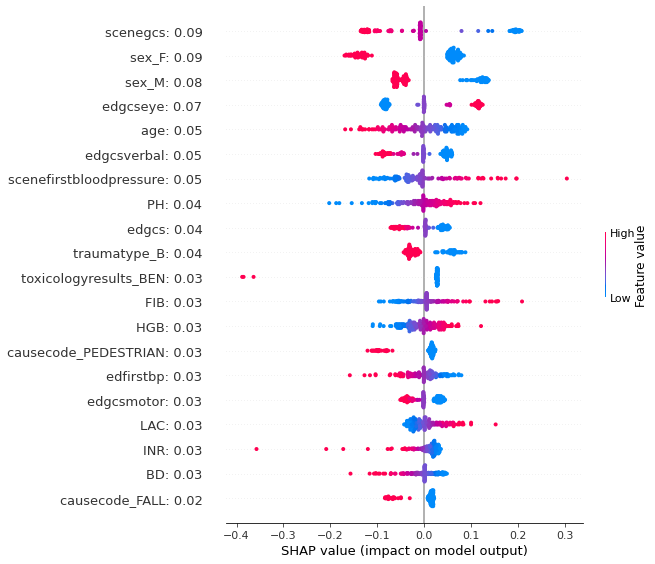

In [29]:
### single learner as oracle
s = RANet()
s.fit(X_train, y_train, w_train)

def s_predict(X):
    return s.predict(X)

explainer = shap.Explainer(s_predict, X_train)

#### showing explanation on cate
shap_values = explainer(X_test)

names = x_train.columns
feature_names = [ a + ": " + str(b) for a,b in zip(names, np.abs(shap_values.values).mean(0).round(2))]

ind = np.argpartition(np.abs(shap_values.values).mean(0).round(2), -10)[-10:]
top_k_results.append(names[ind].tolist())

shap.summary_plot(shap_values, feature_names=feature_names)

Permutation explainer: 167it [00:37,  3.26it/s]                         


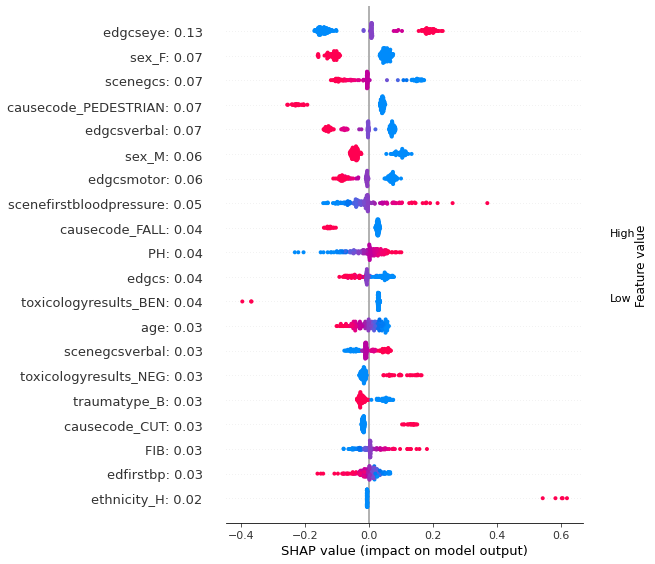

In [30]:
### single learner as oracle
s = XNet()
s.fit(X_train, y_train, w_train)

def s_predict(X):
    return s.predict(X)

explainer = shap.Explainer(s_predict, X_train)

#### showing explanation on cate
shap_values = explainer(X_test)

names = x_train.columns
feature_names = [ a + ": " + str(b) for a,b in zip(names, np.abs(shap_values.values).mean(0).round(2))]

ind = np.argpartition(np.abs(shap_values.values).mean(0).round(2), -10)[-10:]
top_k_results.append(names[ind].tolist())

shap.summary_plot(shap_values, feature_names=feature_names)

In [39]:
import collections

results = collections.Counter(top_k_results)
summary = pd.DataFrame(results.items(), columns=['feature', 'count (%)']).sort_values(by="count (%)", ascending=False)
summary["count (%)"] = np.round(summary["count (%)"]/7,2)*100

summary

,feature,count (%)
8,scenegcs,100.0
7,edgcseye,86.0
14,edgcsverbal,86.0
4,age,57.0
9,sex_F,57.0
10,causecode_FALL,57.0
11,sex_M,57.0
1,HGB,57.0
16,scenegcseye,43.0
5,edgcs,43.0


In [120]:
counter = { 'Scenegcsmotor': 6,"traumatype_P": 3, "BD":1, "Scenegcseye":1, "sex_F":1,
           "Edgcsverbal":4,  "PH":2, "HGB":1, "sex_M":4, "Scenegcs":2 ,"Scenegcsverbal":4 ,
           "Edgeseye": 6, "Toxicologyresults_MARI": 6, "causecode_pedestrian": 4,
           "traumatype_B": 3, "Edfirstpulse": 6, "Causecode_MV":3 ,"Edgcs":2,
           "causecode_GUN":2, "causecode_FALL":1, "Scenefirstbloodpressure":3
          }

In [121]:
summary = pd.DataFrame(counter.items(), columns=['feature', 'count (%)']).sort_values(by="count (%)", ascending=False)
summary["count (%)"] = np.round(summary["count (%)"]/7,2)*100

In [122]:
summary

,feature,count (%)
0,Scenegcsmotor,86.0
15,Edfirstpulse,86.0
12,Toxicologyresults_MARI,86.0
11,Edgeseye,86.0
8,sex_M,57.0
13,causecode_pedestrian,57.0
10,Scenegcsverbal,57.0
5,Edgcsverbal,57.0
1,traumatype_P,43.0
14,traumatype_B,43.0
